## Fine tuning data preparation

* In the DNABERT
    * Their data for pretrain (`6_3k.txt`) didn't really have common sequence with their fine tuning data.
    * There are two fine tuning training data: `train.tsv` (21Mb) and `dev.tsv` (660K)
    * Those data are labelled (delimited by tab) into 2 classes, 0 or 1.


In [459]:
from css_utility import *
import seaborn as sns

In [588]:
# To peek how data look like:
path="../database/dnabert/examples/sample_data/ft/6/"
file_list=[os.path.join(path, file) for file in os.listdir(path)]
file_list

['../database/dnabert/examples/sample_data/ft/6/train.tsv',
 '../database/dnabert/examples/sample_data/ft/6/dev.tsv']

In [4]:
train_pre=pd.read_csv("../database/dnabert/examples/sample_data/pre/6_3k.txt", sep="\n",  \
                      header=None, names=["sequence"])  # data for pretrain
train=pd.read_csv(file_list[0], sep="\t")
dev=pd.read_csv(file_list[1], sep="\t")

In [5]:
train.head()

,sequence,label
0,CACAGC ACAGCC CAGCCA AGCCAG GCCAGC CCAGCC CAGC...,0
1,CTAATC TAATCT AATCTA ATCTAG TCTAGT CTAGTA TAGT...,1
2,GGAAGA GAAGAG AAGAGG AGAGGG GAGGGA AGGGAA GGGA...,1
3,CGAAAG GAAAGC AAAGCA AAGCAA AGCAAT GCAATC CAAT...,1
4,TGACTC GACTCC ACTCCC CTCCCA TCCCAA CCCAAA CCAA...,1


In [6]:
print("len(train_pre): ", len(train_pre))
print("len(train.tsv): ", len(train))
print("len(dev.tsv): ", len(dev))

len(train_pre):  3000
len(train.tsv):  32366
len(dev.tsv):  1000


## Read chr2 for creating the similar dataset

In [7]:
chr2_path=np.sort(all_files)[1]
chr2_path

'../database/bed/unzipped/E002_15_coreMarks_stateno.bed'

In [8]:
df=bed2df_expanded(chr2_path)

In [9]:
all_unit_css=df2unitcss(df)

In [10]:
len(all_unit_css[1])

1215996

In [11]:
with open("../database/temp_files/css_gene_lst_all", "rb") as f:
    css_gene_lst_all=pickle.load(f) # genic area only

In [12]:
len(css_gene_lst_all[0])

5255

In [13]:
len(css_gene_lst_all[0][5000])

97262

In [14]:
# length distribution first!
# then the non-genic region!

In [15]:
def flatLst(lst):
        flatten_lst=[elm for sublst in lst for elm in sublst]
        return flatten_lst

In [16]:
flatten_css_gene_lst=flatLst(css_gene_lst_all)
len(flatten_css_gene_lst)

52260

In [17]:
def len_css_gene(css_gene_lst_all,color="teal"):
    def flatLst(lst):
        flatten_lst=[elm for sublst in lst for elm in sublst]
        return flatten_lst
    flatten_css_gene_lst=flatLst(css_gene_lst_all)
#     fig=plt.figure(figsize=(6,4))    
#     plt.hist(flatten_css_gene_lst)
# #     sns.histplot(flatten_css_gene_lst, kde=False, color=color, log_scale=True, element="step", fill=False)
# #     sns.histplot(flatten_css_gene_lst, kde=False, color=color, log_scale=True)
#     plt.xlabel("Length of each element in dataset", fontsize=12)
#     plt.show()
    return flatten_css_gene_lst

In [18]:
flatten_css_gene_lst=len_css_gene(css_gene_lst_all)

In [19]:
len(flatten_css_gene_lst)

52260

In [20]:
# plt.hist(flatten_css_gene_lst)  ## too large? kernel dies everytime I run this

In [380]:
g_df_chr_lst=whGene2GLChr(whole_gene_file)

In [388]:
max(g_df_chr_lst[0]["TxEnd"])

249213345

# Start here, now we got the new gene list

In [348]:
whole_gene_file

'../database/RefSeq/RefSeq.WholeGene.bed'

In [349]:
new_gene_lst_all=gene_removeDupl(whole_gene_file)

In [350]:
len(new_gene_lst_all)

24

In [397]:
def compNonGene2css(whole_gene_file,df):
    """
    Input: Reference gene file, df (CSS)
    Output: list of chromosome-wise list that contains the css at "non-genic" area only.
    """
#     g_lst_chr=whGene2GLChr(whole_gene_file) # list of gene table df per chromosome

    print("Extracting the CSS on the intergenic region ...")

    ########### new fancy gene table without overlap ###########
    new_gene_lst_all=gene_removeDupl(whole_gene_file)
    ############################################################
    
    css_lst_chr=df2longcss(df) # list of long css per chromosome
    total_chr=len(new_gene_lst_all)
    
    css_Ngene_lst_all=[]
        
    for i in tqdm_notebook(range(total_chr)):
        css=css_lst_chr[i]   # long css of i-th chromosome
        gene_df=new_gene_lst_all[i] # gene df of i-th chromosome
        
        assert gene_df["TxStart"].iloc[0]>=1, "Gene starts from the very first location at {}-th chromosome.".format(i)
        assert gene_df["TxEnd"].iloc[-1]<=len(css), "Gene ends at the very last location at {}-th chromosome.".format(i)  
                
        css_Ngene_lst_chr=[]        
        for j in range(len(gene_df)):
            if j==0:
                ng_start=1 # to avoid any "zero" causing problem 
                ng_end=gene_df["TxStart"].iloc[j]
#                 print("j: {} | ng_start: {} - ng_end: {} ".format(j, ng_start, ng_end)) # for checking
            elif j==len(gene_df)-1: 
                ng_start=gene_df["TxEnd"].iloc[j]
                ng_end=len(css)
#                 print("j: {} | ng_start: {} - ng_end: {} ".format(j, ng_start, ng_end)) # for checking
            else:
                ng_start=gene_df["TxEnd"].iloc[j-1]
                ng_end=gene_df["TxStart"].iloc[j]
#                 print("j: {} | ng_start: {} - ng_end: {} ".format(j, ng_start, ng_end)) # for checking 
        
            css_Ngene=css[ng_start:ng_end]
            css_Ngene_lst_chr.append(css_Ngene)
        
        css_Ngene_lst_all.append(css_Ngene_lst_chr)  
    
    assert len(css_Ngene_lst_all)==total_chr
    print("Done!")
    
    return css_Ngene_lst_all

In [398]:
css_Ngene_lst_all=compNonGene2css(whole_gene_file,df)

Extracting the CSS on the intergenic region ...



Done!


In [399]:
len(css_Ngene_lst_all[0])  # ... but shouldn't be this to be 2188+1?? (so that the initial, final sections are added)

2188

In [ ]:
# Okay, we now have genic, and non-genic area css. Now what? 
# Fine tuning for the dnabert was for 300 bp promoter finding, but our case is different.
# First, I will go with the random cut (5-512) as we did in the pre-training
## first, let us check the length distribution

In [597]:
len(css_Ngene_lst_all[0])

2188

In [593]:
with open ("../database/temp_files/css_gene_lst_all", "rb") as f:
    css_gene_lst_all=pickle.load(f)

In [602]:
len(css_gene_lst_all[0])

5255

In [601]:
len(css_Ngene_lst_all[0])

2188

In [610]:
def countGeneCss(css_gene_lst_all):
    g_css_cnt_all=[]
    g_css_len_all=[]
    tot_chr=len(css_gene_lst_all)
    for chr_no in range(tot_chr):
        g_chr_lst=css_gene_lst_all[chr_no]
        g_css_cnt_all.append(len(g_chr_lst))
        g_css_len_chr=[]
        for i in range(len(g_chr_lst)):
            g_css_len=len(g_chr_lst[i])
            g_css_len_chr.append(g_css_len)  # to let it iterate for chr!
        g_css_len_all.append(g_css_len_chr)
    g_css_len_all=flatLst(g_css_len_all) 
    
    g_css_len_all=list(filter(lambda elm: elm!=0, g_css_len_all))  # remove 0s
        
    # visualization for ng_css_cnt_all (no. of data strips per chromosome)
    fig,(ax1, ax2)=plt.subplots(1,2,figsize=(12,4), sharey=False)
    ax1=sns.histplot(g_css_cnt_all, bins=12, color="cadetblue", element="step", fill=False, ax=ax1)
    ax1.set_xlabel("Count of data strip on Genic region", fontsize=13)
    ax1.set_ylabel("Count", fontsize=13)
    ax1.grid(b=None)
    
    # visualization for ng_css_cnt_all (no. of data strips per chromosome)
    ax2=sns.histplot(g_css_len_all, bins=15, log_scale=True, color="crimson", element="step", fill=False, ax=ax2)
    ax2.set_xlabel("Length of CSS on Genic region", fontsize=13)
    ax2.set_ylabel("Count", fontsize=13)
    ax2.grid(b=None)
            
    return g_css_cnt_all,g_css_len_all

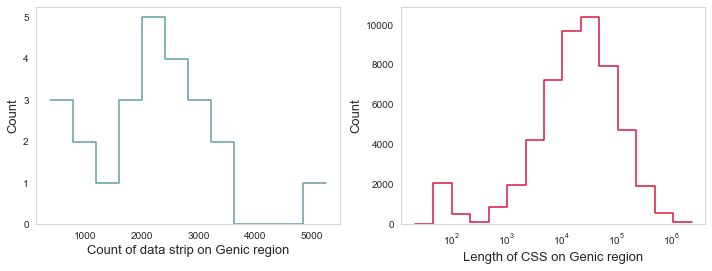

In [611]:
g_css_cnt_all,g_css_len_all=countGeneCss(css_gene_lst_all)

In [584]:
with open ("../database/temp_files/css_Ngene_lst_all", "wb") as f:
    pickle.dump(css_Ngene_lst_all, f)

In [582]:
def countNgeneCss(css_Ngene_lst_all):
    ng_css_cnt_all=[]
    ng_css_len_all=[]
    tot_chr=len(css_Ngene_lst_all)
    for chr_no in range(tot_chr):
        ng_chr_lst=css_Ngene_lst_all[chr_no]
        ng_css_cnt_all.append(len(ng_chr_lst))
        ng_css_len_chr=[]
        for i in range(len(ng_chr_lst)):
            ng_css_len=len(ng_chr_lst[i])
            ng_css_len_chr.append(ng_css_len)  # to let it iterate for chr!
        ng_css_len_all.append(ng_css_len_chr)
    ng_css_len_all=flatLst(ng_css_len_all) 
    
    ng_css_len_all=list(filter(lambda elm: elm!=0, ng_css_len_all))  # remove 0s
        
    # visualization for ng_css_cnt_all (no. of data strips per chromosome)
    fig,(ax1, ax2)=plt.subplots(1,2,figsize=(12,4), sharey=False)
    ax1=sns.histplot(ng_css_cnt_all, bins=12, color="navy", element="step", fill=False, ax=ax1)
    ax1.set_xlabel("Count of data strip on Intergenic region", fontsize=13)
    ax1.set_ylabel("Count", fontsize=13)
    ax1.grid(b=None)
    
    # visualization for ng_css_cnt_all (no. of data strips per chromosome)
    ax2=sns.histplot(ng_css_len_all, bins=15, log_scale=True, color="maroon", element="step", fill=False, ax=ax2)
    ax2.set_xlabel("Length of CSS on Intergenic region", fontsize=13)
    ax2.set_ylabel("Count", fontsize=13)
    ax2.grid(b=None)
            
    return ng_css_cnt_all,ng_css_len_all

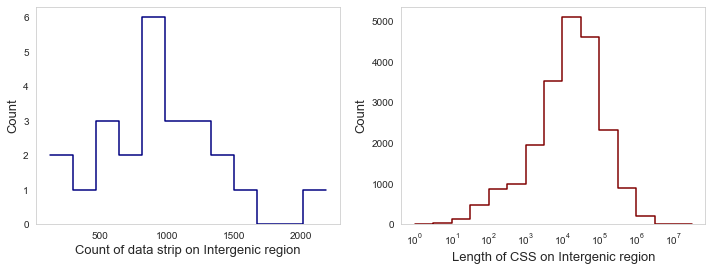

In [583]:
ng_css_cnt_all,ng_css_len_all=countNgeneCss(css_Ngene_lst_all)

In [ ]:
# randomly cut the string for fine tuning

def css4FineTune_ranCUT_Kmer(css_lst, genic=True, chr_no=2,num1=5,num2=510, k=3, weight_rn=False, v_name="v1.01"):
    """
    Usage: css4FineTune_ranCUT_Kmer(df,num1,num2, k, weight_rn, v_name)
    
    - css_lst: Either css_gene_lst_all or css_Ngene_lst_all
    - genic: True if css_gene_lst_all, False if css_Ngene_lst_all
    - chr_no: no. of chromosome
    - num1: cut range start
    - num2: cut range end
    - weight_rn: 
      if True: random with weighted, 50% of chance to be num2, 50% random between num1 and num2
      if False: random between num1 and num2
    - k: kmer
    - v_name: version name to be used as a file name 
      (Conventionally, 01 was used for weighted_rn False, 02 for True
       v1 just stands for telomere is set to be 50 unit)
    
    output: randomly cut w15 css for one chromosome for fine tuning data.
    """
    
    css_lst_chr=css_lst[chr_no]  # only for one chromosome 
    
    if genic:
        css_lst_chr_wotelo=css_lst_chr
    else:
        css_lst_chr_wotelo=css_lst_chr[50:-50] #cut the telomere when intergenic (because they contain telo)

    splitted=[]
    prev=0

    ori_lst=[elm for elm in range(num1,num2+1)]   # list of num between num1 and num2
    sin_lst=[num2]*len(ori_lst)   # list of all num2 (length is the same of ori_lst)
    tot_lst=ori_lst+sin_lst
    
    while True:
        
        if weight_rn:
            n=random.choice(tot_lst)

        else:
            n=random.randint(num1,num2)
        
        splitted.append(ch1_unit_css_wotelo[prev:prev+n])
        prev=prev+n
        if prev >= len(ch1_unit_css_wotelo)-1:
            break
   
    ch1_unit_css_wotelo_kmer=[seq2kmer(item, k) for item in splitted]
    
      
    path='../database/fine_tune/'
    fn_base="chr"+str(chr_no)+"_"+str(k)+v_name   # version 1.01_pre (Oct. 2022) : telo 50 unit, rn 200-1000
                                                              # version 1.01 (Oct. 2022) : telo 50, rn 5 - 510
    ext=".txt"
          
    fn=path+fn_base+ext  # file name

    with open(fn,"w") as save_file:
        save_file.write("\n".join(ch1_unit_css_wotelo_kmer))
          
    return print("unit-length css of chr{} cut randomly(weighted range:{}-{}) for {}mer was saved at {}".format(chr_no, num1, num2, k,fn))

In [670]:
len(css_gene_lst_all)

24

In [637]:
a=['AAAAABBBBBCCCCC','AAAAABBBBB']

In [638]:
for i in a:
    

['AAAAABBBBBCCCCC', 'AAAAABBBBB']

In [656]:
unit_lst=[]
unit_bp=5
for elm in a:   
    let_set=list(set(elm))
    unit_elm=''
    print(elm)
    for uniq in let_set:
        uniq_cnt=elm.count(uniq)
        print(uniq, uniq_cnt)
        unit_elm+=uniq*int((uniq_cnt)/unit_bp)
    unit_lst.append(unit_elm)
    assert int(len(elm))==int(len(unit_elm)*unit_bp)

AAAAABBBBBCCCCC
A 5
B 5
C 5
AAAAABBBBB
A 5
B 5


In [ ]:
def long2unitCSS(long_css, unit_bp=200):
    """
    * description *
    long_css is the result of the function "df2longcss" (real length css), 
    and this function aims to convert it into the result of the "function df2unitcss",
    which is shortest possible version of the css.
    Why? because pre-train data for ChromBERT is done by unit-length, 
    and the genic/intergenic css is acquired as a long-css
    """
    unit_lst_all=[]
    for chr_no in long_css:
        long_css_chr=long_css[chr_no]   # chromosome-wise    
        unit_lst=[]
        for elm in long_css_chr:   
            let_set=list(set(elm))  # unique characters  ########## NOOOOOO, it cannot be done like this, because there can be repetitive pattern.
            
            unit_elm=''
#             print(elm)
            for uniq in let_set:
                uniq_cnt=elm.count(uniq)
#                 print(uniq, uniq_cnt)
                unit_elm+=uniq*int((uniq_cnt)/unit_bp)
            unit_lst.append(unit_elm)
            assert int(len(elm))==int(len(unit_elm)*unit_bp)
            
        unit_lst_all.append(unit_lst)
            

In [673]:
a=['AAAAABBBBBCCCCCAAAAACCCCC','DDDDDEEEEEAAAAABBBBBAAAAABBBBB']

In [683]:
# the idea is to separate, count, combine
for elm in a:
#     print(elm)
    unit_str=''
    for i, let_str in enumerate(elm):
        if i==0:
            unit_str+=let_str
        elif i==len(elm)-1:
            continue
        elif let_str!=elm[i-1]:
            unit_str+=let_str
        else:
            continue
    print(unit_str)

ABCAC
DEABAB


In [657]:
unit_lst

['ABC', 'AB']

In [662]:
isinstance(2, int)

True

In [665]:
for length in df["length"]:
    if length%200:
        print(length)

In [376]:
# #### backup

# def compNonGene2css(whole_gene_file,df):
#     """
#     Input: Reference gene file, df (CSS)
#     Output: list of chromosome-wise list that contains the css at "non-genic" area only.
#     """
#     g_lst_chr=whGene2GLChr(whole_gene_file) # list of gene table df per chromosome
#     css_lst_chr=df2longcss(df) # list of long css per chromosome
#     total_chr=len(g_lst_chr)
    
#     css_Ngene_lst_all=[]
#     for i in tqdm_notebook(range(total_chr)):
#         css=css_lst_chr[i]   # long css of i-th chromosome
#         gene_df=g_lst_chr[i] # gene df of i-th chromosome
        
#         assert gene_df["TxStart"].iloc[0]>=1, "Gene starts from the very first location at {}-th chromosome.".format(i)
#         assert gene_df["TxEnd"].iloc[-1]<=len(css), "Gene ends at the very last location at {}-th chromosome.".format(i)  
                
#         css_Ngene_lst_chr=[]
#         for j in range(len(gene_df)):
#             if j==0:
#                 ng_start=1 # to avoid any "zero" causing problem 
#                 ng_end=gene_df["TxStart"].iloc[j]
# #                 css_gene=css[g_start:g_end] 
#             elif j==len(gene_df)-1: 
#                 ng_start=gene_df["TxEnd"].iloc[j]
#                 ng_end=len(css)-1
#             else:
#                 ng_start=gene_df["TxEnd"].iloc[j-1]
#                 if j <=3:
#                     print("j: {} | ng_start: {}".format(j, ng_start))
#                 ng_end=gene_df["TxStart"].iloc[j]
#                 if j <=3:
#                     print("j: {} | ng_end: {}".format(j, ng_end))
        
#             css_Ngene=css[ng_start:ng_end]
#             css_Ngene_lst_chr.append(css_Ngene)
        
#         css_Ngene_lst_all.append(css_Ngene_lst_chr)   
#     assert len(css_Ngene_lst_all)==total_chr
#     return css_Ngene_lst_all

In [33]:
############ Oh,,, genes are overlapped! I need to make a gene table not to overlap.. to show the non-genic (intergenic)


In [88]:
# function to visualize how many genes are sharing the start and end position on genome

def count_samePos(whole_gene_file='../database/RefSeq/RefSeq.WholeGene.bed'):
    g_df_chr_lst=whGene2GLChr(whole_gene_file)
    cnt_same_start_all=[]
    pro_same_start_all=[]
    cnt_same_end_all=[]
    pro_same_end_all=[]
    tot_chr_no=len(g_df_chr_lst)
    
    ########### count the same start position ###########
    def count_sameStart(g_df_chr_lst,chr_no):
        cnt_same_start=0
        tot_start=len(g_df_chr_lst[chr_no])
        for i in range(len(g_df_chr_lst[chr_no])):
            chr1=g_df_chr_lst[chr_no]["TxStart"]
            if i==0:
                continue
            elif chr1.iloc[i]==chr1.iloc[i-1]:
                cnt_same_start+=1  # how many same start in rows
            else:
                continue
        prop_same_start=cnt_same_start/tot_start
        return cnt_same_start, prop_same_start
    
    ########### count the same end position ############
    def count_sameEnd(g_df_chr_lst,chr_no):
        cnt_same_end=0
        tot_end=len(g_df_chr_lst[chr_no])
        for i in range(len(g_df_chr_lst[chr_no])):
            chr1=g_df_chr_lst[chr_no]["TxEnd"]       
            if i==0:
                continue
            elif chr1.iloc[i]==chr1.iloc[i-1]:
                cnt_same_end+=1  # how many same start in rows
            else:
                continue
        prop_same_end=cnt_same_end/tot_end
        return cnt_same_end, prop_same_end
    ####################################################
    
    for chr_no in tqdm_notebook(range(tot_chr_no)):
        cnt_same_start, prop_same_start = count_sameStart(g_df_chr_lst,chr_no)
        cnt_same_end, prop_same_end = count_sameEnd(g_df_chr_lst,chr_no)
        
        cnt_same_start_all.append(cnt_same_start)
        pro_same_start_all.append(prop_same_start)
        cnt_same_end_all.append(cnt_same_end)
        pro_same_end_all.append(prop_same_end)
        
    dict_cnt={"cnt_same_start":cnt_same_start_all, "cnt_same_end":cnt_same_end_all}
    dict_pro={"pro_same_start":pro_same_start_all, "pro_same_end":pro_same_end_all}
    df_cnt=pd.DataFrame(dict_cnt)
    df_pro=pd.DataFrame(dict_pro)
    
    ###### Visualization ######
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5), sharey=False)
    ax1=sns.violinplot(data=df_cnt, palette="pastel", linewidth=0.7, saturation=0.5, ax=ax1)
    ax1.set_ylabel("Count", fontsize=15)
    ax2=sns.violinplot(data=df_pro, palette="husl", linewidth=0.7, saturation=0.5, ax=ax2)
    ax2.set_ylim([0.2,0.8])
    ax2.set_ylabel("Proportion", fontsize=15)
    plt.show()

    return df_cnt, df_pro

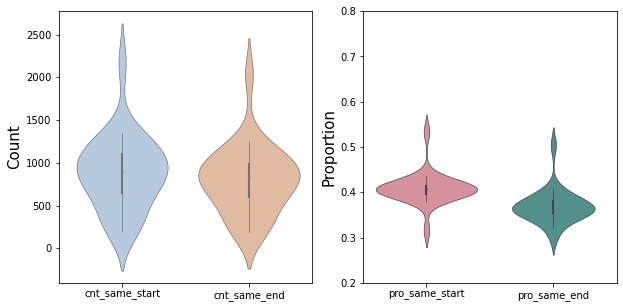

In [89]:
df_cnt, df_pro=count_samePos(whole_gene_file)

In [ ]:
# Now, plan to properly collapse the gene_df.iloc

In [91]:
gene_df.iloc[:100]

,chromosome,TxStart,TxEnd,name
1463,chr1,11873,14409,NR_046018
1460,chr1,14361,29370,NR_024540
1458,chr1,17368,17436,NR_106918
1455,chr1,17368,17436,NR_128720
1457,chr1,17368,17436,NR_107062
...,...,...,...,...
1548,chr1,1334909,1337426,NR_015434
1547,chr1,1337275,1342693,NM_017971
1544,chr1,1353799,1356824,NM_001145210
1545,chr1,1353799,1356824,NM_001243536


In [95]:
# test using this strip
test_df=gene_df[["chromosome","TxStart","TxEnd"]].iloc[:100]

In [96]:
test_df["TxStart"].iloc[0]

11873

In [110]:
len(test_df)

100

In [150]:
len(g_df_chr_lst[0])

5255

In [337]:
def removeOverlapDF(test_df):    
    new_lst=[]
    for i in range(len(test_df)):
        start=test_df["TxStart"].iloc[i]
        end=test_df["TxEnd"].iloc[i]

        exist_pair=(start,end)

        if i==0:
            new_pair=exist_pair
            new_lst.append(new_pair)        
        else:
            start_pre=test_df["TxStart"].iloc[i-1]
            end_pre=test_df["TxEnd"].iloc[i-1]

            # first, concatenate all the shared start
            if start==start_pre:
                new_end=max(end, end_pre)
                new_pair=(start, new_end)
            # second, concatenate all the shared end
            elif end==end_pre:
                new_start=min(start, start_pre)
                new_pair=(new_start, end)
            else:    
                new_pair=exist_pair

        new_lst.append(new_pair) 
    new_lst=list(dict.fromkeys(new_lst))
    
    mod_lst=[[start, end] for (start, end) in new_lst] # as a list element

    for j, elm in enumerate(mod_lst):
        start, end = elm[0], elm[1]

        if j==0:
            continue
        else:
            start_pre=mod_lst[j-1][0]
            end_pre=mod_lst[j-1][1]

            if end_pre>=end:
                mod_lst[j][0]=mod_lst[j-1][0]  # if end_pre is larger than end, replace start as start_pre
                mod_lst[j][1]=mod_lst[j-1][1]  # if end_pre is larger than end, replace end as end_pre

            elif start <=end_pre:
                mod_lst[j][0]=mod_lst[j-1][0]  # current start=start_pre
                mod_lst[j-1][1]=max(mod_lst[j][1],mod_lst[j-1][1])  # end_pre = end

            else:
                continue
           
    mod_lst=[tuple(elm) for elm in mod_lst]
    fin_lst=list(dict.fromkeys(mod_lst))
    gene_collapsed_df=pd.DataFrame(fin_lst, columns=["TxStart", "TxEnd"])
 
    return gene_collapsed_df

In [391]:
def gene_removeDupl(whole_gene_file='../database/RefSeq/RefSeq.WholeGene.bed'):
    g_df_chr_lst=whGene2GLChr(whole_gene_file)
    new_gene_lst_all=[]
    for chr_no in range(len(g_df_chr_lst)):
        gene_df=g_df_chr_lst[chr_no]
        gene_collapsed_df=removeOverlapDF(gene_df)
        new_gene_lst_all.append(gene_collapsed_df)
    return new_gene_lst_all # list of chromosome-wise dataframe for collapsed gene table

In [392]:
new_gene_lst_all= gene_removeDupl(whole_gene_file)

In [394]:
new_lst_all[0]

,TxStart,TxEnd
0,11873,29370
1,30365,30503
2,34610,36081
3,69090,70008
4,134772,140566
...,...,...
2183,249104650,249120154
2184,249120575,249120642
2185,249132376,249143716
2186,249144202,249153315
